## Семинар 7: "Методы оптимизации"

ФИО: Черепнина Мария Сергеевна

In [51]:
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader
%matplotlib inline

На этом семинаре мы попробуем сравнить различные методы оптимизации: GD, Momentum, NAG, Adagrad, Adadelta, Adam.

### Часть 1: Реализация методов

Полезная функция: plt.contour
Для всех экспериментов подберите параметры так, чтобы метод сошелся к ближайшему локальному минимуму. Все методы следует запускать из одной и той же точки.

<i> 1.1 Реализуйте методы GD, Momentum, NAG, Adagrad, Adadelta, Adam.</i>

In [17]:
def GD(f, df, start_dot, step = 0.1, max_iter = 100):
    answer = np.empty((N, start.shape[0]))
    answer[0] = start_dot
    for i in range(1, max_iter):
        answer[i] = answer[i - 1] - df(answer[i - 1]) * step 
    return answer

In [3]:
def Momentum(f, df, start_dot, step = 0.1, max_iter = 100, gamma=0.9):
    answer = np.empty((N, start.shape[0]))
    answer[0] = start_dot
    nu = np.empty(start.shape)
    for i in range(1, max_iter):
        nu = gamma * nu + step * df(answer[i - 1])
        answer[i] = answer[i - 1] - nu
    return answer

In [4]:
def NAG(f, df, start_dot, step = 0.1, max_iter = 100, gamma=0.9):
    answer = np.empty((N, start.shape[0]))
    answer[0] = start_dot
    nu = np.empty(start.shape)
    for i in range(1, max_iter):
        nu = gamma * nu + step * df(answer[i - 1] - gamma * nu)
        answer[i] = answer[i - 1] - nu
    return answer

In [5]:
def Adagrad(f, df, start_dot, step = 0.1, max_iter = 100, eps = 10 ** (-8)):
    answer = np.empty((N, start.shape[0]))
    answer[0] = start_dot
    g = np.empty(start.shape)
    G = 0
    for i in range(1, max_iter):
        g = df(answer[i - 1])
        G += np.sum(g ** 2)
        answer[i] = answer[i - 1] - step / np.sqrt(eps + G) * g
    return answer

In [6]:
def Adadelta(f, df, start_dot, step = 0.1, max_iter = 100, eps = 10 ** (-8), gamma=0.9):
    answer = np.empty((N, start.shape[0]))
    answer[0] = start_dot
    E_dr = 0
    E_g = 0
    dr = np.empty(start.shape)
    g = np.empty(start.shape)
    for i in range(1, max_iter):
        g = df(answer[i - 1])
        E_g = gamma * E_g + (1 - gamma) * np.sum(g ** 2)
        dr = np.sqrt(E_dr + eps) / np.sqrt(E_g + eps) * g
        E_dr = gamma * E_dr + (1 - gamma) * np.sum(dr ** 2)
        answer[i] = answer[i - 1] - dr
    return answer

In [7]:
def Adam(f, df, start_dot, step = 0.1, max_iter = 100, eps = 10 ** (-8), b1=0.9, b2=0.999):
    answer = np.empty((N, start.shape[0]))
    answer[0] = start_dot
    m = 0
    nu = 0
    for i in range(1, max_iter):
        g = df(answer[i - 1])
        m = b1 * m + (1 - b1) * g
        nu = b1 * nu + (1 - b1) * np.sum(g ** 2)
        m_ = m / (1 - b1 ** i)
        nu_ = nu / (1 - b2 ** i)
        answer[i] = answer[i - 1] - step / np.sqrt(nu_ + eps) * m_
    return answer

Рисовалка графиков:

In [8]:
def make_plot(f, df, start_dot, N=100):
    resGD = GD(f=f, df= df, start_dot=start_dot, max_iter=N)
    resMomentum = Momentum(f=f, df=df, start_dot=start_dot, max_iter=N)
    resNAG = NAG(f=f, df= df, start_dot=start_dot, max_iter=N)
    resAdagrad = Adagrad(f=f, df=df, start_dot=start_dot, max_iter=N)
    resAdadelta = Adadelta(f=f, df=df, start_dot=start_dot, max_iter=N)
    resAdam = Adam(f=f, df= df, start_dot=start_dot, max_iter=N)

    plt.plot(resGD[:, 0], resGD[:, 1], label='GD')
    plt.plot(resMomentum[:, 0], resMomentum[:, 1], label='Momentum')
    plt.plot(resNAG[:, 0], resNAG[:, 1], label='NAG')
    plt.plot(resAdagrad[:, 0], resAdagrad[:, 1], label='Adagrad')
    plt.plot(resAdadelta[:, 0], resAdadelta[:, 1], label='Adadelta')
    plt.plot(resAdam[:, 0], resAdam[:, 1], label='Adam')

    X = np.arange(-3, 3, 0.05)
    Y = np.arange(-3, 3, 0.05)
    size = X.shape[0]
    Z = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            Z[i, j] = f((X[i], Y[j]))
    con = plt.contour(X, Y, Z)
    plt.clabel(con)

    plt.legend()
    plt.show()

<i> 1.2 Сравните эти методы на функции $J(x, y) = x^2+y^2$</i>

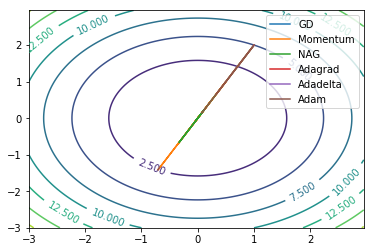

In [36]:
f = lambda X: X[0]**2+X[1]**2
df = lambda X: np.array([2*X[0], 2*X[1]])

N = 100
start = np.array([1, 2])

make_plot(f, df, start)

<i>1.3 Сравните эти методы на функции $J(x, y) = x^2sin(x)+y^2sin(y)$</i>

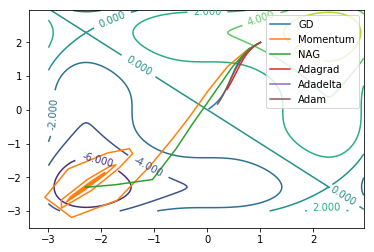

In [37]:
f = lambda X: X[0] ** 2 * np.sin(X[0]) + X[1] ** 2 * np.sin(X[1])
df = lambda X: np.array([2 * X[0] * np.sin(X[0]) + X[0] ** 2 * np.cos(X[0]),
                         2 * X[1] * np.sin(X[1]) + X[1] ** 2 * np.cos(X[1])])

N = 100
start = np.array([1, 2])

make_plot(f, df, start)

<i>1.3 Сравните эти методы на функции $J(x,y)=x^2sin(x^2)+y^2sin(y^2)$</i>

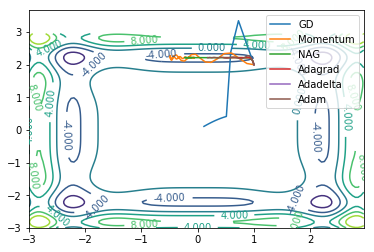

In [48]:
f = lambda X: X[0] ** 2 * np.sin(X[0] ** 2) + X[1] ** 2 * np.sin(X[1] ** 2)
df = lambda X: np.array([2 * X[0] * np.sin(X[0] ** 2) + X[0] ** 3 * np.cos(X[0] ** 2) * 2,
                         2 * X[1] * np.sin(X[1] ** 2) + X[1] ** 3 * np.cos(X[1] ** 2) * 2])

N = 100
start = np.array([1, 2])

resGD = GD(f=f, df= df, start_dot=start, max_iter=N)
resMomentum = Momentum(f=f, df=df, start_dot=start, max_iter=N, step=0.01)
resNAG = NAG(f=f, df= df, start_dot=start, max_iter=N, step=0.01)
resAdagrad = Adagrad(f=f, df=df, start_dot=start, max_iter=N)
resAdadelta = Adadelta(f=f, df=df, start_dot=start, max_iter=N)
resAdam = Adam(f=f, df= df, start_dot=start, max_iter=N)

plt.plot(resGD[:, 0], resGD[:, 1], label='GD')
plt.plot(resMomentum[:, 0], resMomentum[:, 1], label='Momentum')
plt.plot(resNAG[:, 0], resNAG[:, 1], label='NAG')
plt.plot(resAdagrad[:, 0], resAdagrad[:, 1], label='Adagrad')
plt.plot(resAdadelta[:, 0], resAdadelta[:, 1], label='Adadelta')
plt.plot(resAdam[:, 0], resAdam[:, 1], label='Adam')

X = np.arange(-3, 3, 0.05)
Y = np.arange(-3, 3, 0.05)
size = X.shape[0]
Z = np.zeros((size, size))
for i in range(size):
    for j in range(size):
        Z[i, j] = f((X[i], Y[j]))
con = plt.contour(X, Y, Z)
plt.clabel(con)

plt.legend()
plt.show()

###  Часть 2: Обучение нейронной сети

<i> 2.1 Сравните графики обучения для полносвязной нейросети на методах Adam, Adagrad, AdaDelta и SGD (на MNIST). </i>

In [53]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [62]:
def train(network, epochs, learning_rate, optim, ravel_init=True):
    loss = nn.NLLLoss()
    optimizer = optim(network.parameters(), lr=learning_rate)
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                if ravel_init:
                    X = X.view(X.size(0), -1)
                network.zero_grad()
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                loss_batch.backward()
                optimizer.step()
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                if ravel_init:
                    X = X.view(X.size(0), -1)
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            print('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                        train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.plot(train_loss_epochs, label='Train')
            plt.plot(test_loss_epochs, label='Test')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.subplot(1, 2, 2)
            plt.plot(train_accuracy_epochs, label='Train accuracy')
            plt.plot(test_accuracy_epochs, label='Test accuracy')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.show()
    except KeyboardInterrupt:
        pass

### Adam:

Epoch 9... (Train/Test) NLL: 0.028/0.096	Accuracy: 0.991/0.977


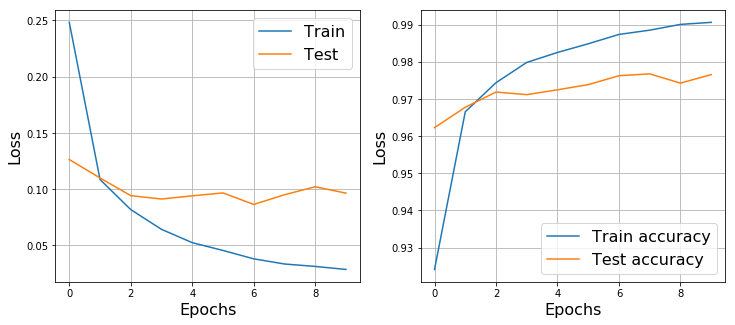

In [63]:
network = nn.Sequential(nn.Linear(784, 100),
                        nn.ReLU(),
                        nn.Linear(100, 100),
                        nn.ReLU(),
                        nn.Linear(100, 10),
                        nn.LogSoftmax())

train(network, 10, 0.001, optim=torch.optim.Adam)

### Adagrad:

Epoch 9... (Train/Test) NLL: 0.238/0.234	Accuracy: 0.932/0.933


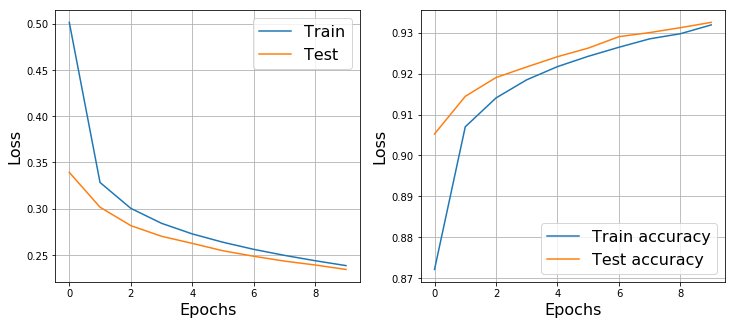

In [64]:
network = nn.Sequential(nn.Linear(784, 100),
                        nn.ReLU(),
                        nn.Linear(100, 100),
                        nn.ReLU(),
                        nn.Linear(100, 10),
                        nn.LogSoftmax())

train(network, 10, 0.001, optim=torch.optim.Adagrad)

### Adadelta:

Epoch 9... (Train/Test) NLL: 0.515/0.479	Accuracy: 0.872/0.883


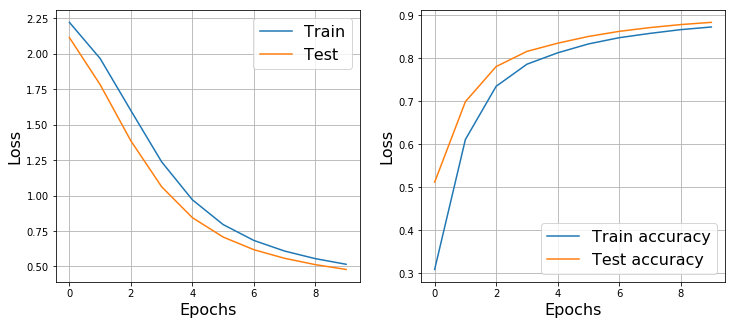

In [65]:
network = nn.Sequential(nn.Linear(784, 100),
                        nn.ReLU(),
                        nn.Linear(100, 100),
                        nn.ReLU(),
                        nn.Linear(100, 10),
                        nn.LogSoftmax())

train(network, 10, 0.001, optim=torch.optim.Adadelta)

<i> 2.2 Сравните графики обучения для сверточной нейросети на методах Adam, Adagrad, AdaDelta и SGD. </i>

In [66]:
image_size = 28
channels = 1
class ConvClassifier(nn.Module):
    def __init__(self, image_size):
        super(ConvClassifier, self).__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(channels, 8, 3, padding=1),
                                         nn.ReLU(),
                                         nn.MaxPool2d(2),
                                         nn.Conv2d(8, 16, 3, padding=1),
                                         nn.ReLU(),)
        self.linear_layers = nn.Sequential(nn.Linear(image_size // 2 * image_size // 2 * 16, 10),
                                           nn.LogSoftmax(dim=1))
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

### Adam:

Epoch 9... (Train/Test) NLL: 0.010/0.056	Accuracy: 0.996/0.987


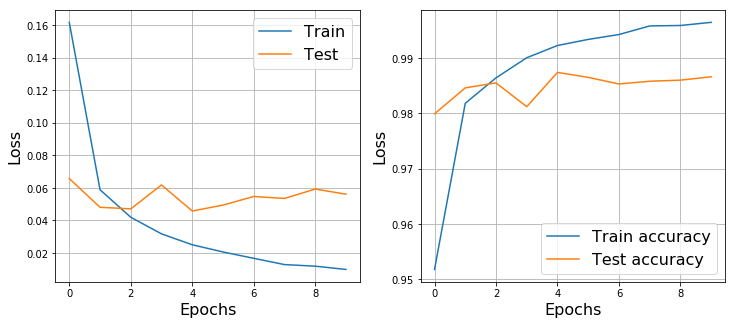

In [68]:
network = ConvClassifier(image_size=28)
train(network, 10, 0.001, ravel_init=False, optim=torch.optim.Adam)

### Adagrad:

Epoch 9... (Train/Test) NLL: 0.167/0.156	Accuracy: 0.952/0.955


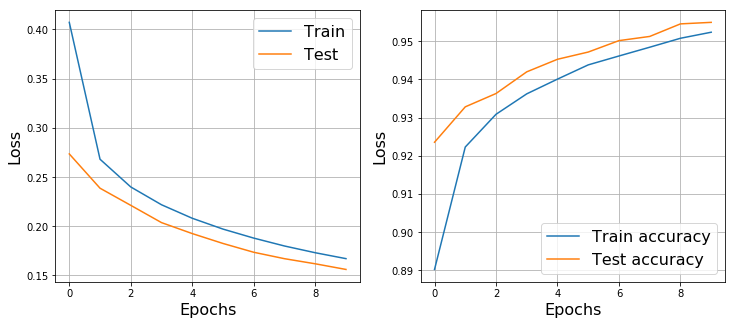

In [69]:
network = ConvClassifier(image_size=28)
train(network, 10, 0.001, ravel_init=False, optim=torch.optim.Adagrad)

### Adadelta:

Epoch 9... (Train/Test) NLL: 0.375/0.352	Accuracy: 0.891/0.901


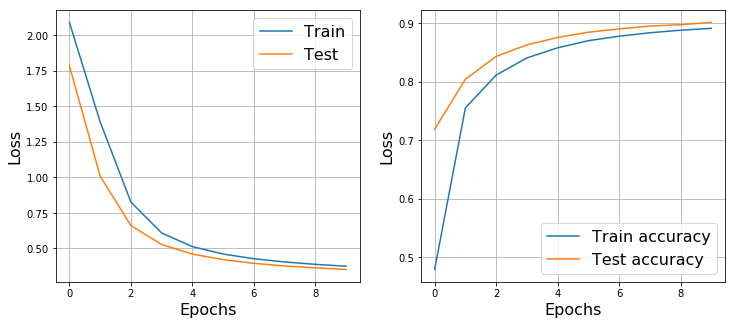

In [70]:
network = ConvClassifier(image_size=28)
train(network, 10, 0.001, ravel_init=False, optim=torch.optim.Adadelta)

## вывод

**Adam** показал наилучшие результаты и в случае полносвязанной сети, и в случае сверточной. Но у Adam'а больше других методов отличаются заначения на train и test

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: